In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
dataset = load_boston()
dataset.data.shape

(506, 13)

In [3]:
x_full,y_full = dataset.data,dataset.target
n_sample = x_full.shape[0]
n_feature = x_full.shape[1]
x_full.shape

(506, 13)

## 为完整数据放入缺失值
确认我们希望放入缺失值等比例，在这里我们假设是50%，那总共就要有3289个数据缺失

In [4]:
rng = np.random.RandomState(0)
missing_rate = 0.5
n_missing_samples = int(np.floor(n_sample*n_feature*missing_rate))
n_missing_samples

3289

In [5]:
# n_feature = 13 , n_sample = 506
missing_feature = rng.randint(0,n_feature,n_missing_samples)
missing_sample = rng.randint(0,n_sample,n_missing_samples)
# choice
# missing_sample = rng.choice(n_sample,n_missing_samples,replace=false)


In [6]:
x_missing = x_full.copy()
y_missing = y_full.copy()
# 测试语法
# x_missing[[0,1],[1,2]] = 22
# x_missing[[[0,1,2]],[[1,2,3]]] = 22
# x_missing

In [7]:
x_missing[missing_sample,missing_feature] = np.nan
# x_missing

In [8]:
x_missing = pd.DataFrame(x_missing)
x_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


In [9]:
# 使用 平均数 或者中位数 填充Age
simple_inputer = SimpleImputer();#默认均值
median_inputer = SimpleImputer(strategy="median");#中位数
zero_inputer = SimpleImputer(strategy="constant",fill_value=0);#用0填补


x_missing_mean = simple_inputer.fit_transform(x_missing)
x_missing_mean

x_missing_zero = zero_inputer.fit_transform(x_missing)
x_missing_zero

array([[0.0000e+00, 1.8000e+01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 0.0000e+00,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 0.0000e+00, 3.9690e+02,
        7.8800e+00]])

In [10]:
# 检查缺失值
x_missing_zero = pd.DataFrame(x_missing_zero)
x_missing_zero.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [11]:
# 从缺失值最小的纬度开始 填补缺失值
x_missing_reg = x_missing.copy()
sort_index = np.argsort(x_missing.isnull().sum(axis=0)).values

In [12]:
# 构建我们新特征矩阵 和新标签
for i in sort_index:
    df = x_missing_reg
    fill_c = df.iloc[:,i]
    df_change = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    df_0 = SimpleImputer(missing_values=np.nan,strategy="constant",fill_value=0).fit_transform(df_change)
    # 找出 训练集 和测试集
    Y_train = fill_c[fill_c.notnull()]
    Y_test = fill_c[fill_c.isnull()]
    X_train = df_0[Y_train.index,:]
    X_test = df_0[Y_test.index,:]

    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(X_train,Y_train)
    Y_predict = rfc.predict(X_test)
    # 回填数据
    x_missing_reg.loc[x_missing_reg.iloc[:,i].isnull(),i] = Y_predict

In [13]:
x_missing_reg

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.204215,18.00,7.8378,0.15,0.538000,6.65918,65.200,4.090000,1.00,296.00,17.926,387.6995,4.9800
1,0.027310,0.00,6.0169,0.00,0.469000,6.13931,78.900,4.967100,2.00,289.07,18.384,396.9000,9.1400
2,0.027290,12.37,7.0700,0.00,0.464818,7.18500,61.100,4.170471,2.00,242.00,17.994,386.8455,5.1511
3,0.090136,13.54,3.2866,0.00,0.458000,6.92786,45.800,4.649936,3.54,222.00,18.700,393.0248,5.7014
4,0.066326,0.00,2.1800,0.00,0.463355,7.14700,55.128,4.804245,3.79,255.27,18.700,394.2006,5.3300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.451253,3.01,10.4209,0.00,0.573000,6.23882,69.100,2.807129,1.00,275.92,21.000,390.5999,9.6700
502,0.045270,0.00,11.9300,0.00,0.573000,6.12000,76.700,2.287500,1.00,273.00,19.040,396.9000,9.0800
503,0.478751,2.11,11.9300,0.39,0.573000,6.97600,91.000,2.585735,3.48,276.39,21.000,389.7968,5.6400
504,0.109590,0.00,11.9300,0.10,0.573000,6.37188,89.300,2.699641,1.00,253.47,21.000,393.4500,6.4800


In [14]:
X = [x_full,x_missing_mean,x_missing_zero,x_missing_reg]
mse = []
for x in X:
    estimator = RandomForestRegressor(random_state=0,n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring="neg_mean_squared_error",cv=5).mean()
    mse.append(scores * -1)

In [15]:
[*zip(["x_full","x_missing_mean","x_missing_zero","x_missing_reg"],mse)]

[('x_full', 21.571667100368845),
 ('x_missing_mean', 40.848037216676374),
 ('x_missing_zero', 49.626793201980185),
 ('x_missing_reg', 20.045496660706654)]

/Users/xuhuan/opt/anaconda3/envs/Ai-python/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


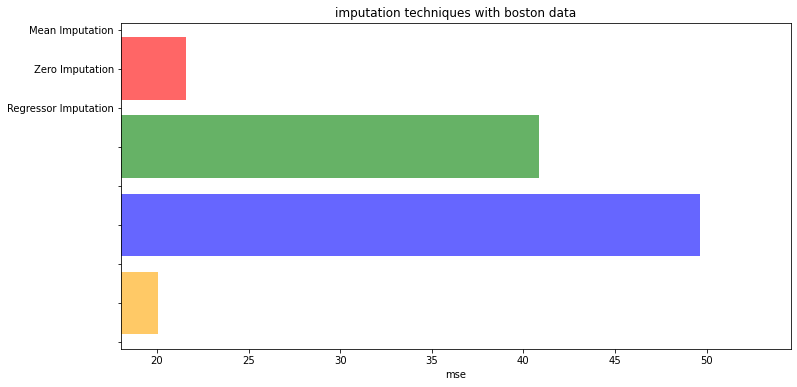

In [17]:
x_labels = ['Full Data','Mean Imputation','Zero Imputation','Regressor Imputation']
colors = ['r','g','b','orange']
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i,mse[i],color = colors[i],alpha=0.6,align='center')
ax.set_title('imputation techniques with boston data')
ax.set_xlim(left=np.min(mse) * 0.9,right= np.max(mse) * 1.1 )
ax.set_xlabel("mse")
ax.invert_yaxis()
ax.set_yticklabels(x_labels)
plt.show()
